In [273]:
import mxnet as mx
from tqdm import tqdm, tqdm_notebook
from mxnet import np, npx
import mxnet as mx
from mxnet import init
from mxnet import nd, autograd, gluon
from mxnet.gluon import nn
import mxnet.gluon.probability as mgp
from mxnet.gluon.probability import StochasticBlock
import numpy as onp
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import animation, rc
from IPython.display import HTML
import celluloid
from sklearn.datasets import make_moons
npx.set_np()
data_ctx = mx.cpu()
model_ctx = mx.gpu(0)

In [36]:
def load_array(data_arrays, batch_size, is_train=True):
    """Construct a Gluon data loader"""
    dataset = gluon.data.ArrayDataset(*data_arrays)
    return gluon.data.DataLoader(dataset, batch_size, shuffle=is_train)

In [331]:
class Generator(mgp.Transformation, gluon.HybridBlock):
    def __init__(self, n_hidden=10, n_layers=0, n_output=2, act_type='tanh', **kwargs):
        super(Generator, self).__init__(**kwargs)
        with self.name_scope():
            self.net = nn.HybridSequential(prefix='encoder')
            for _ in range(n_layers):
                self.net.add(nn.Dense(n_hidden, activation=act_type))
            self.net.add(nn.Dense(n_output, activation=None))
    
    def _forward_compute(self, x):
        F = self.F
        return self.net(x)
    

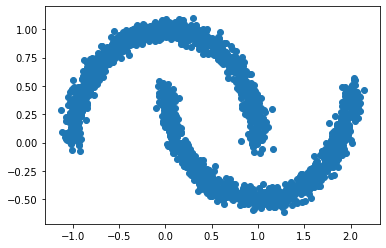

In [302]:
X = np.array(make_moons(2000, noise=0.05)[0], dtype='float32')
data = X
plt.scatter(data.asnumpy()[:, 0], data.asnumpy()[:, 1])

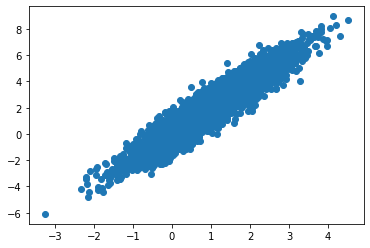

In [327]:
X = np.random.normal(size=(5000, 2))
A = np.array([[1, 2], [-0.1, 0.5]])
b = np.array([1, 2])
data = X.dot(A) + b
plt.scatter(data.asnumpy()[:, 0], data.asnumpy()[:, 1])

In [361]:
lr_D, lr_G, latent_dim, num_epochs = 0.05, 0.005, 2, 10
batch_size = 100

Discriminator = nn.HybridSequential()
Discriminator.add(nn.Dense(5, activation='tanh'),
          nn.Dense(3, activation='tanh'),
          nn.Dense(1))
Discriminator.hybridize()

f = Generator()
f.hybridize()
z = mgp.Normal(np.zeros((latent_dim,), ctx=model_ctx), np.ones((latent_dim,), ctx=model_ctx))
gz = mgp.TransformedDistribution(z, f)

data_iter = load_array((data,), batch_size)

f.initialize(force_reinit=True, ctx=model_ctx)
Discriminator.initialize(force_reinit=True, ctx=model_ctx)
trainer_G = gluon.Trainer(f.collect_params(),
                              'adam', {'learning_rate': lr_D})
trainer_D = gluon.Trainer(Discriminator.collect_params(),
                              'adam', {'learning_rate': lr_D})

In [ ]:
for epoch in tqdm_notebook(range(num_epochs)):
    for X in data_iter:
        with autograd.record():
            fake_data = gz.sample((batch_size, 2))
            logits_real = Discriminator(X.as_in_ctx(model_ctx))
            logits_fake = Discriminator(fake_data)
            label_real = mgp.Bernoulli(logit=logits_real)
            label_fake = mgp.Bernoulli(logit=logits_fake)
            loss_d = -(label_real.log_prob(np.ones_like(logits_real)) + 
                       label_fake.log_prob(np.zeros_like(logits_fake))) / 2
            loss_g = -(label_fake.log_prob(np.ones_like(logits_fake)))
        loss_d.backward(retain_graph=True)
        trainer_D.step(batch_size)
        loss_g.backward(retain_graph=True)
        trainer_G.step(batch_size)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [359]:
for epoch in tqdm_notebook(range(num_epochs)):
    for X in data_iter:
        # Discriminator
        with autograd.record():
            fake_data = gz.sample((batch_size, latent_dim)).detach()
            logits_real = Discriminator(X.as_in_ctx(model_ctx))
            logits_fake = Discriminator(fake_data)
            label_real = mgp.Bernoulli(logit=logits_real)
            label_fake = mgp.Bernoulli(logit=logits_fake)
            loss_d = -(label_real.log_prob(np.ones_like(logits_real)) + 
                       label_fake.log_prob(np.zeros_like(logits_fake))) / 2
        loss_d.backward()
        trainer_D.step(batch_size)
        # Generator
        with autograd.record():
            fake_data = gz.sample((batch_size, latent_dim))
            logits_fake = Discriminator(fake_data)
            label_fake = mgp.Bernoulli(logit=logits_fake)
            loss_g = -(label_fake.log_prob(np.ones_like(logits_fake)))
        loss_g.backward()
        trainer_G.step(batch_size)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


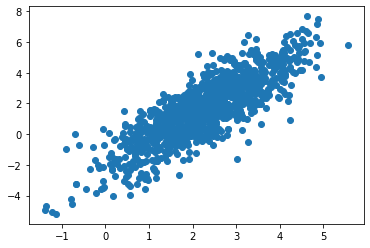

In [360]:
fake_data = gz.sample((1000, 2))
plt.scatter(fake_data.asnumpy()[:, 0], fake_data.asnumpy()[:, 1])